In [2]:
import nfl_data_py as nfl
import pandas as pd
import os
import numpy as np
import urllib.request

#displaying data imports
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg
import seaborn as sns


#basic ML imports
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [3]:
#clean 2024 data

df_twofour = nfl.import_pbp_data([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], downcast=True, cache=False, alt_path=None, include_participation=False)

#regular season data only
df_twofour = df_twofour.loc[df_twofour.season_type=='REG']

#remove kick offs, field goals, kneels, etc - only plays with passes, runs, and penalties
#df_twofour = df_twofour.loc[(df_twofour.play_type.isin(['no_play','pass','run'])) & (df_twofour.epa.isna()==False)]

#match play call to play type, so QB scrambles still considered pass plays
df_twofour.loc[df_twofour['pass']==1, 'play_type'] = 'pass'
df_twofour.loc[df_twofour.rush==1, 'play_type'] = 'run'

#reset index to skip missing numbers
df_twofour.reset_index(drop=True, inplace=True)

df_twofour.head()

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,None,None,None,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-0.497988,NaN,NaN,NaN,NaN,NaN,0.452352,-45.235191
3,72.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-0.378146,NaN,NaN,NaN,NaN,NaN,0.588882,-58.888157
4,93.0,2014_01_BUF_CHI,2014090702,CHI,BUF,REG,1,BUF,away,CHI,...,0.0,0.0,-1.542538,0.509138,5.985426,2.0,1.0,1.0,0.975684,2.431589


In [4]:
df_twofour_scores = df_twofour[['game_id', 'posteam', 'home_team', 'total_home_score', 'away_team', 'total_away_score']]
df_twofour_scores.head()
df_twofour_scores.iloc[110:120]

,game_id,posteam,home_team,total_home_score,away_team,total_away_score
110,2014_01_BUF_CHI,BUF,CHI,17.0,BUF,17.0
111,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
112,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
113,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
114,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
115,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
116,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
117,2014_01_BUF_CHI,CHI,CHI,17.0,BUF,17.0
118,2014_01_BUF_CHI,BUF,CHI,17.0,BUF,17.0
119,2014_01_BUF_CHI,BUF,CHI,17.0,BUF,17.0


In [5]:
#Points

df_scores = (
        df_twofour_scores.groupby(['game_id', 'home_team', 'away_team'], as_index=False)
        .agg({
            'total_home_score': 'max',
            'total_away_score': 'max'
        })
        .rename(columns={
            'game_id': 'Game ID',
            'home_team': 'Home Team',
            'away_team': 'Away Team',
            'total_home_score': 'Max Home Score',
            'total_away_score': 'Max Away Score'
        })
    )
df_scores


,Game ID,Home Team,Away Team,Max Home Score,Max Away Score
0,2014_01_BUF_CHI,CHI,BUF,20.0,23.0
1,2014_01_CAR_TB,TB,CAR,14.0,20.0
2,2014_01_CIN_BAL,BAL,CIN,16.0,23.0
3,2014_01_CLE_PIT,PIT,CLE,30.0,27.0
4,2014_01_GB_SEA,SEA,GB,36.0,16.0
...,...,...,...,...,...
2874,2024_18_NO_TB,TB,NO,27.0,19.0
2875,2024_18_NYG_PHI,PHI,NYG,20.0,13.0
2876,2024_18_SEA_LA,LA,SEA,25.0,30.0
2877,2024_18_SF_ARI,ARI,SF,47.0,24.0


In [6]:
df_team_scores = (
    df_scores.assign(
        Teams=df_scores[["Home Team", "Away Team"]].values.tolist(),
        Scores=df_scores[["Max Home Score", "Max Away Score"]].values.tolist()
    )
    .explode(["Teams", "Scores"])  
    .reset_index(drop=True)        
    .loc[:, ["Game ID", "Teams", "Scores"]]  
    .rename(columns={"Teams": "Team", "Scores": "Score"}) 
)

df_team_scores

,Game ID,Team,Score
0,2014_01_BUF_CHI,CHI,20.0
1,2014_01_BUF_CHI,BUF,23.0
2,2014_01_CAR_TB,TB,14.0
3,2014_01_CAR_TB,CAR,20.0
4,2014_01_CIN_BAL,BAL,16.0
...,...,...,...
5753,2024_18_SEA_LA,SEA,30.0
5754,2024_18_SF_ARI,ARI,47.0
5755,2024_18_SF_ARI,SF,24.0
5756,2024_18_WAS_DAL,DAL,19.0


In [7]:
df_off_stats = df_twofour[['game_id', 'home_team', 'away_team', 'posteam', 'epa', 'pass_length', 'air_yards', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 'yards_gained', 'total_home_rush_epa', 'total_away_rush_epa']]

df_off_stats.head()

,game_id,home_team,away_team,posteam,epa,pass_length,air_yards,air_epa,yac_epa,comp_air_epa,comp_yac_epa,yards_gained,total_home_rush_epa,total_away_rush_epa
0,2014_01_BUF_CHI,CHI,BUF,None,-0.000000,None,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2014_01_BUF_CHI,CHI,BUF,BUF,-0.000000,None,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000
2,2014_01_BUF_CHI,CHI,BUF,BUF,-0.497988,None,NaN,NaN,NaN,0.0,0.0,2.0,0.497988,-0.497988
3,2014_01_BUF_CHI,CHI,BUF,BUF,-0.378146,None,NaN,NaN,NaN,0.0,0.0,2.0,0.876134,-0.876134
4,2014_01_BUF_CHI,CHI,BUF,BUF,-1.542538,short,11.0,1.884436,-3.426974,0.0,0.0,0.0,0.876134,-0.876134


In [8]:


'''
_rush_epa is screwed up and needs to be fixed
'''


df_off_filtered = df_off_stats.dropna(subset=['posteam'])

df_off_filtered = df_off_filtered[  
    (df_off_filtered['posteam'] == df_off_filtered['home_team']) | 
    (df_off_filtered['posteam'] == df_off_filtered['away_team'])
]

df_off_stats_cons = (
    df_off_filtered.groupby([
        'game_id', 'posteam'], as_index=False)
    .agg({
        'epa': 'mean',        
        'air_yards': 'sum',
        'air_epa': 'mean',
        'yac_epa': 'mean',
        'yards_gained': 'mean',
        'total_home_rush_epa': 'mean',
        'total_away_rush_epa': 'mean'
    })
)

df_off_stats_cons.head()
    

,game_id,posteam,epa,air_yards,air_epa,yac_epa,yards_gained,total_home_rush_epa,total_away_rush_epa
0,2014_01_BUF_CHI,BUF,0.039684,190.0,0.532829,-0.456361,4.864865,-0.760195,0.760195
1,2014_01_BUF_CHI,CHI,-0.043388,366.0,0.352935,-0.435496,4.852273,-0.418643,0.418643
2,2014_01_CAR_TB,CAR,-0.025454,242.0,0.407620,-0.081483,3.929412,4.065518,-4.065518
3,2014_01_CAR_TB,TB,-0.140763,245.0,0.413351,-0.562981,3.882353,4.727853,-4.727853
4,2014_01_CIN_BAL,BAL,-0.091836,489.0,0.490079,-0.468602,4.147059,1.802482,-1.802482


In [12]:

#double check this and everything after

df_off_stats_cons = df_off_stats_cons.rename(columns={"game_id": "Game ID", "posteam": "Team"}) 
df_off_stats_cons.head()

,Game ID,Team,epa,air_yards,air_epa,yac_epa,yards_gained,total_home_rush_epa,total_away_rush_epa
0,2014_01_BUF_CHI,BUF,0.039684,190.0,0.532829,-0.456361,4.864865,-0.760195,0.760195
1,2014_01_BUF_CHI,CHI,-0.043388,366.0,0.352935,-0.435496,4.852273,-0.418643,0.418643
2,2014_01_CAR_TB,CAR,-0.025454,242.0,0.407620,-0.081483,3.929412,4.065518,-4.065518
3,2014_01_CAR_TB,TB,-0.140763,245.0,0.413351,-0.562981,3.882353,4.727853,-4.727853
4,2014_01_CIN_BAL,BAL,-0.091836,489.0,0.490079,-0.468602,4.147059,1.802482,-1.802482


In [13]:
merged_off = pd.merge(df_team_scores, df_off_stats_cons, on =["Game ID", "Team"], how="inner")

merged_off.head()

,Game ID,Team,Score,epa,air_yards,air_epa,yac_epa,yards_gained,total_home_rush_epa,total_away_rush_epa
0,2014_01_BUF_CHI,CHI,20.0,-0.043388,366.0,0.352935,-0.435496,4.852273,-0.418643,0.418643
1,2014_01_BUF_CHI,BUF,23.0,0.039684,190.0,0.532829,-0.456361,4.864865,-0.760195,0.760195
2,2014_01_CAR_TB,TB,14.0,-0.140763,245.0,0.413351,-0.562981,3.882353,4.727853,-4.727853
3,2014_01_CAR_TB,CAR,20.0,-0.025454,242.0,0.407620,-0.081483,3.929412,4.065518,-4.065518
4,2014_01_CIN_BAL,BAL,16.0,-0.091836,489.0,0.490079,-0.468602,4.147059,1.802482,-1.802482


In [14]:
'''
model is atrocious and needs to be worked on
'''


# Define features (X) and target (y)
features = ['epa', 'air_yards', 'air_epa', 'yac_epa', 'yards_gained']
target = 'Score'

X = merged_off[features]
y = merged_off[target]

In [15]:
#test_size= 20% of data is used for testing, and 80% for training. Use 42 as conventional default for random_state
'''FYI
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
returns MAE: 8.18, RMSE: 10.17


Gridsearch results are: Tuned Model - MAE: 7.78, RMSE: 9.72'''


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# for awareness -- below defines number of trees, learning rate, depth of decision trees, reproducibility
model = xgb.XGBRegressor(
    n_estimators=250, 
    learning_rate=0.02, 
    max_depth=1, 
    min_child_weight=8,  
    gamma=0.1,             
    colsample_bytree=0.5,    
    random_state=42
)

In [16]:
# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 5.18, RMSE: 6.68


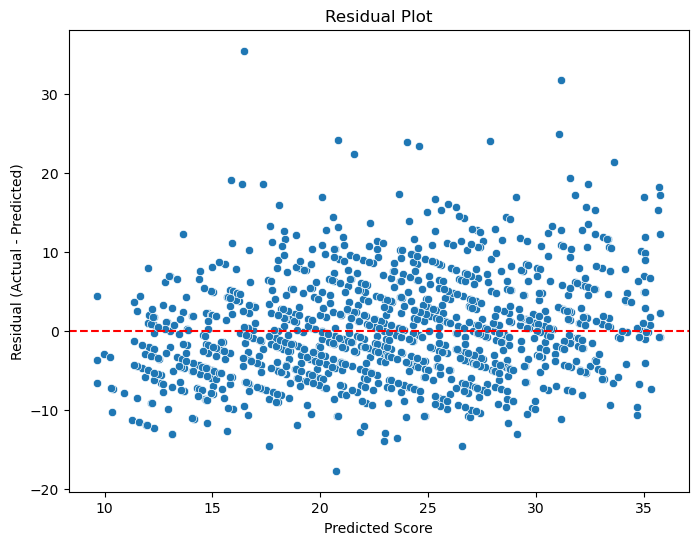

In [18]:
#calculating errors with manual tuning

residuals = y_test - y_pred  

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color="red", linestyle="--")  
plt.xlabel("Predicted Score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

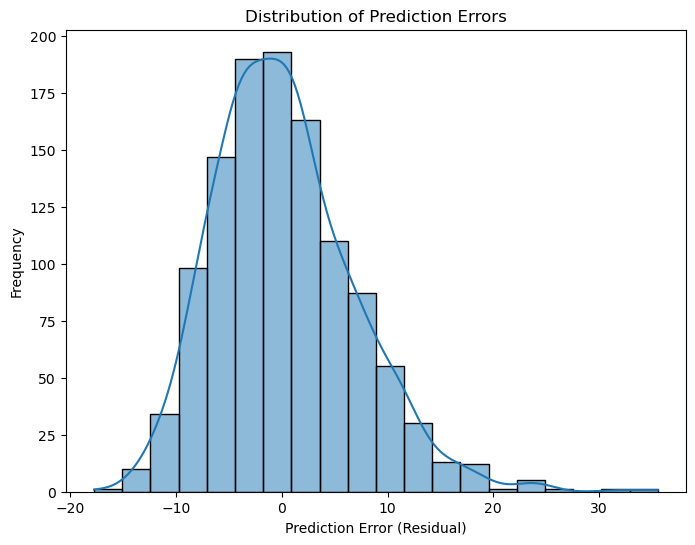

In [19]:
#bar graph showing distribution of errors using manual tuning

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()